#### 190824_encoder-decoder-shareweight

## 读图片

In [14]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys, os
# sys.path.insert(1, '/home/xianr/data/utils/jupyter/xianpf/Projects/探究deeplab图像加载过程')
sys.path.insert(1, '/home/xianr/TurboRuns/msiip')
# import cityscapes
from dataloaders.datasets import cityscapes
# from dataloader import DataLoader
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from dataloaders.utils import decode_seg_map_sequence
# from dataloader_utils import decode_seg_map_sequence


class FakeArgs():
    pass
args = FakeArgs()
args.workers = 0
# args.workers = 1
args.dataset = 'cityscapes'
args.batch_size = 4
# args.batch_size = 1
args.base_size = 513
args.crop_size = 513
args.cuda = False

kwargs = {'num_workers': args.workers, 'pin_memory': True}
train_set = cityscapes.CityscapesSegmentation(args, split='train')
val_set = cityscapes.CityscapesSegmentation(args, split='val')
num_class = train_set.NUM_CLASSES
train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, **kwargs)
val_loader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, **kwargs)
print(len(train_loader), len(val_loader))

Found 2975 train images
Found 500 val images
744 125


In [66]:
sample = next(iter(train_loader))

In [67]:
image, target = sample['image'], sample['label']

In [17]:
# type(image)
image.shape
# plt.imshow(image[0].permute(1,2,0))

torch.Size([4, 3, 513, 513])

In [18]:
import torch.nn as nn
encoder = nn.Conv2d(3, 21, kernel_size=7, stride=2, padding=3, bias=False)
decoder = nn.Conv2d(21, 3, kernel_size=7, stride=2, padding=3, bias=False)

In [19]:
encoder._parameters.keys()

odict_keys(['weight', 'bias'])

In [20]:
encoder._parameters['bias']

In [21]:
encoder._parameters['weight'].shape

torch.Size([21, 3, 7, 7])

In [22]:
e1 = encoder(image)

In [23]:
e1.shape

torch.Size([4, 21, 257, 257])

In [24]:
encoder.weight.shape

torch.Size([21, 3, 7, 7])

In [25]:
decoder.weight.shape

torch.Size([3, 21, 7, 7])

In [28]:
encoder.weight.permute(1, 0, 2, 3).shape

torch.Size([3, 21, 7, 7])

In [31]:
from torch.nn.parameter import Parameter

In [33]:
decoder.weight = Parameter(encoder.weight.permute(1, 0, 2, 3), requires_grad=False)

In [34]:
d1 = decoder(e1)

In [35]:
d1.shape

torch.Size([4, 3, 129, 129])

# 期望输出：21个类在64个component上的投影
- 一个选项是输出b, 21, h, w
- 这就要求weight是21, 21, 7, 7

<img width="300px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides.gif">

In [36]:
3, 2, 1, 1

(3, 2, 1, 1)

In [37]:
# plt.figure(figsize = (12,8))
# plt.imshow(target[0])

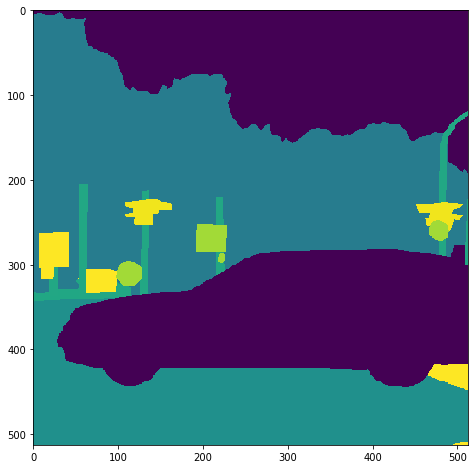

In [68]:
target_grid_image = make_grid(decode_seg_map_sequence(target[:1].numpy(), dataset=args.dataset), 3, normalize=False, range=(0, 255))
plt.figure(figsize = (12,8))
plt.imshow(target_grid_image[0])

In [69]:
# plt.figure(figsize = (12,8))
# plt.imshow(image[0][0])

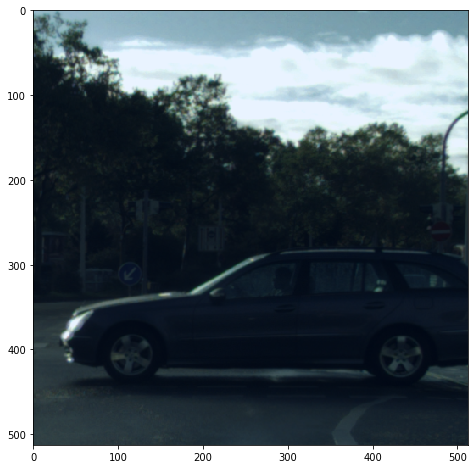

In [70]:
# plt.imshow(image[0].permute(1,2,0))
plt.figure(figsize = (12,8))
color_img = image[0].permute(1,2,0)
color_img = (color_img - color_img.min())/(color_img.max() - color_img.min())
plt.imshow(color_img)

## 各种采样

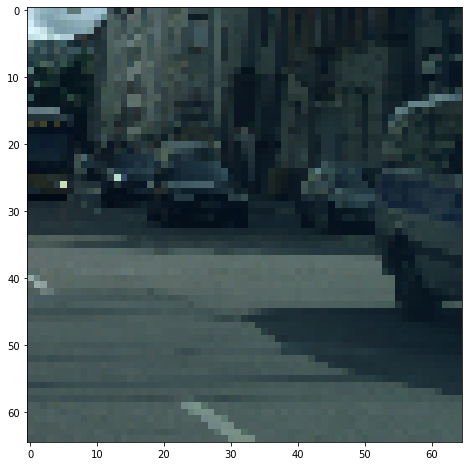

In [9]:
import torch.nn.functional as F

img_tensor_513 = F.interpolate(image, size=(65,65), mode='bilinear', align_corners=True)
plt.figure(figsize = (12,8))
color_img = img_tensor_513[0].permute(1,2,0)
color_img = (color_img - color_img.min())/(color_img.max() - color_img.min())
plt.imshow(color_img)

# 模型部分的处理和操作
- MSI-share-middle

In [10]:
# from msisharemiddle import MultiScaleInitShareMiddle
from multiscaleinit.msisharemiddle import MultiScaleInitShareMiddle
model = MultiScaleInitShareMiddle(num_classes=num_class)

In [11]:
checkpoint = torch.load('/home/xianr/TurboRuns/msiip/run/cityscapes/msi-share-middle/experiment_5/checkpoint.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [12]:
output = model(image)

In [13]:
output.shape

torch.Size([4, 19, 513, 513])

In [14]:
torch.max(output[:3], 1)[1].shape

torch.Size([3, 513, 513])

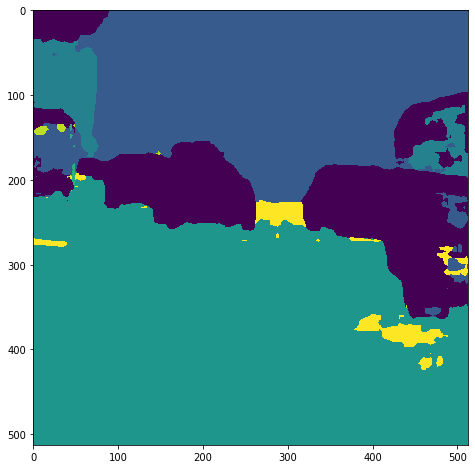

In [15]:
output_grid_image = make_grid(decode_seg_map_sequence(torch.max(output[:1], 1)[1].numpy(), dataset=args.dataset), 3, normalize=False, range=(0, 255))
plt.figure(figsize = (12,8))
plt.imshow(output_grid_image[0])
del output

# Look inside 模型内部推演

In [16]:
from multiscaleinit.build import build_init_multiscale_images

In [17]:
x513, x257, x129, x65, x33 = build_init_multiscale_images(image)

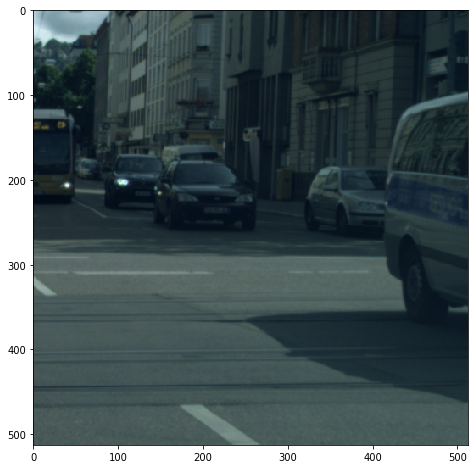

In [18]:
color_img = x513[0].permute(1,2,0)
color_img = (color_img - color_img.min())/(color_img.max() - color_img.min())
plt.figure(figsize = (12,8))
plt.imshow(color_img)

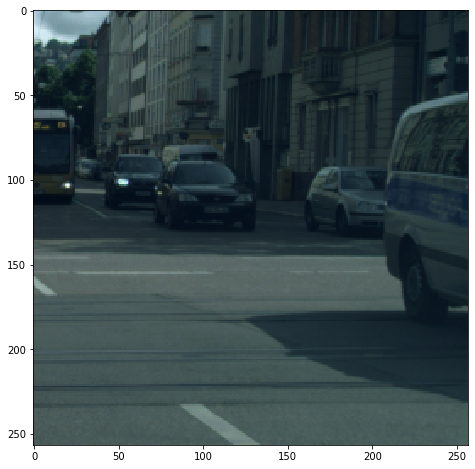

In [19]:
color_img = x257[0].permute(1,2,0)
color_img = (color_img - color_img.min())/(color_img.max() - color_img.min())
plt.figure(figsize = (12,8))
plt.imshow(color_img)

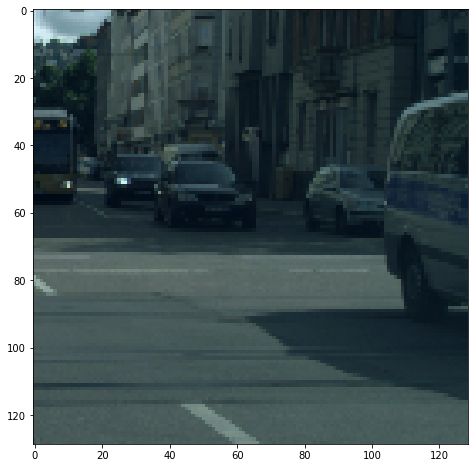

In [20]:
color_img = x129[0].permute(1,2,0)
color_img = (color_img - color_img.min())/(color_img.max() - color_img.min())
plt.figure(figsize = (12,8))
plt.imshow(color_img)

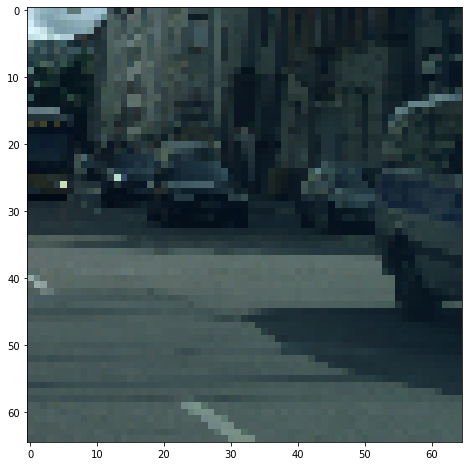

In [21]:
color_img = x65[0].permute(1,2,0)
color_img = (color_img - color_img.min())/(color_img.max() - color_img.min())
plt.figure(figsize = (12,8))
plt.imshow(color_img)

# sobel初级处理

# 完整单scale处理

In [22]:
def process_each_scale(self, x):
    bt_size, chn_size, h_size, w_size = x.shape
    x_c2b = x.view(bt_size*chn_size, 1, h_size, w_size)
    # process each channel with shared weights
    line_x_1c = self.line_conv(x_c2b)
    sobel_x_1c = self.sobel_conv(x_c2b)

    line_x = line_x_1c.view(bt_size, chn_size*4, h_size, w_size)
    sobel_x = sobel_x_1c.view(bt_size, chn_size*4, h_size, w_size)

    x = torch.cat((x, line_x, sobel_x), 1)
    mixc_x = F.relu(self.bn_mix(self.conv_mix(x)))

    x_conv1 = F.relu(self.bn_1(self.conv_1(mixc_x)))
    x_conv2 = F.relu(self.bn_2(self.conv_2(x_conv1)))

    convx_up_to_x = F.interpolate(x_conv2, size=(h_size, w_size), mode='bilinear', align_corners=True)
    out_x = torch.cat((mixc_x, convx_up_to_x), 1)

    return out_x

In [23]:
out_513 = process_each_scale(model, x513)

In [24]:
out_513.shape

torch.Size([4, 160, 513, 513])

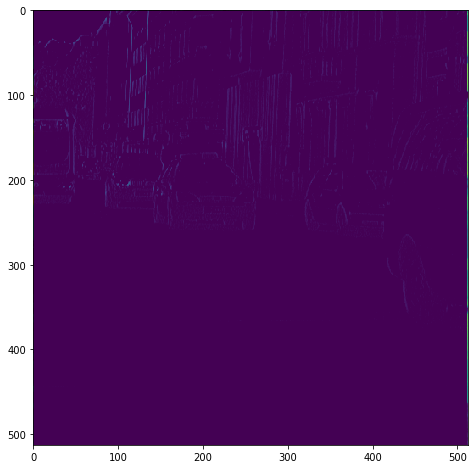

In [26]:
plt.figure(figsize = (12,8))
plt.imshow(out_513.detach().numpy()[0][0])

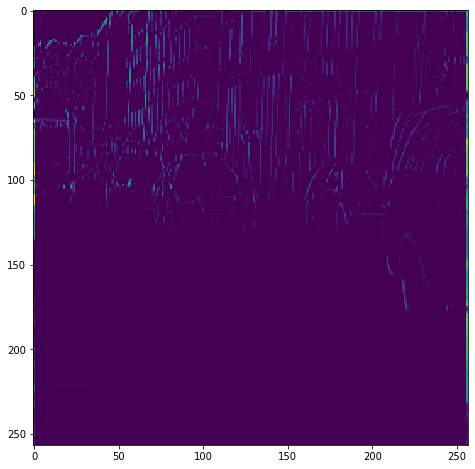

In [27]:
out_257 = process_each_scale(model, x257)
plt.figure(figsize = (12,8))
plt.imshow(out_257.detach().numpy()[0][0])

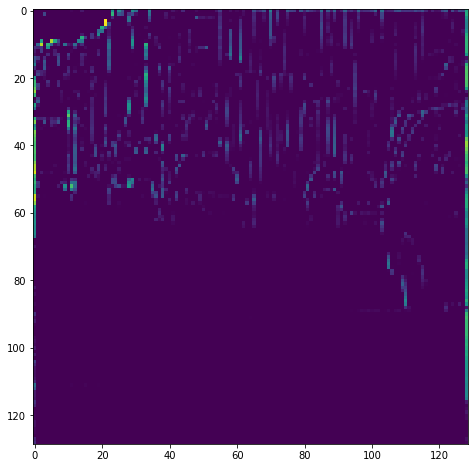

In [28]:
out_129 = process_each_scale(model, x129)
plt.figure(figsize = (12,8))
plt.imshow(out_129.detach().numpy()[0][0])

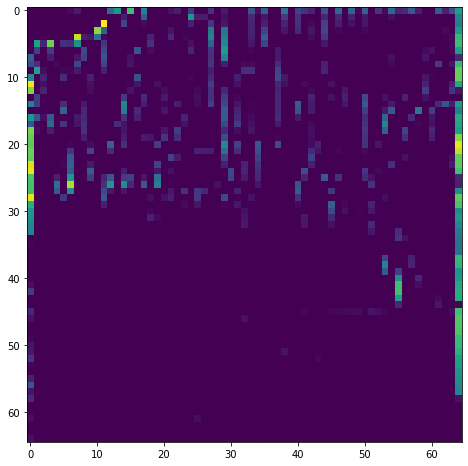

In [29]:
out_65 = process_each_scale(model, x65)
plt.figure(figsize = (12,8))
plt.imshow(out_65.detach().numpy()[0][0])

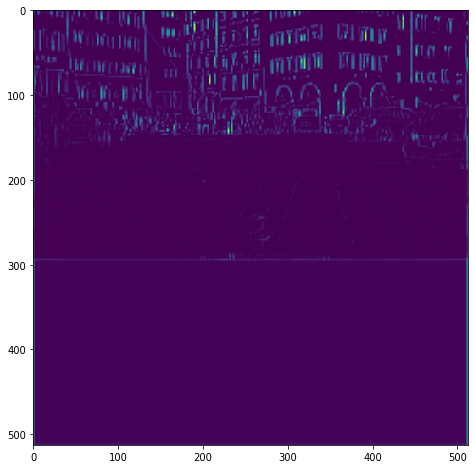

In [65]:
out_257 = F.interpolate(out_257, size=(image.shape[2], image.shape[3]), mode='bilinear', align_corners=True)
plt.figure(figsize = (12,8))
plt.imshow(out_257.detach().numpy()[2][0])

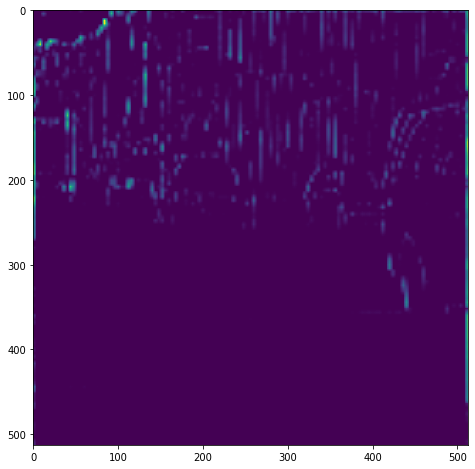

In [32]:
out_129 = F.interpolate(out_129, size=(image.shape[2], image.shape[3]), mode='bilinear', align_corners=True)
plt.figure(figsize = (12,8))
plt.imshow(out_129.detach().numpy()[0][0])

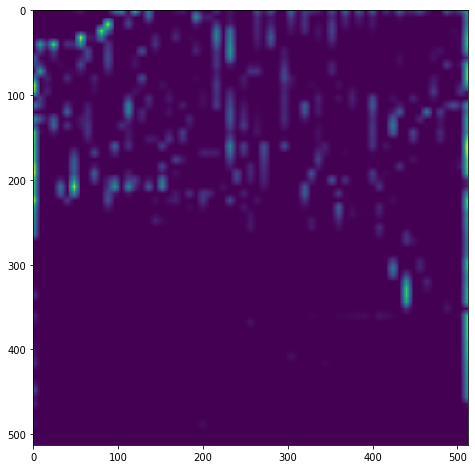

In [33]:
out_65 = F.interpolate(out_65, size=(image.shape[2], image.shape[3]), mode='bilinear', align_corners=True)
plt.figure(figsize = (12,8))
plt.imshow(out_65.detach().numpy()[0][0])

In [34]:
out = out_513+out_257+out_129+out_65

In [35]:
out = model.last_conv(out)

In [44]:
out.shape

torch.Size([4, 19, 513, 513])

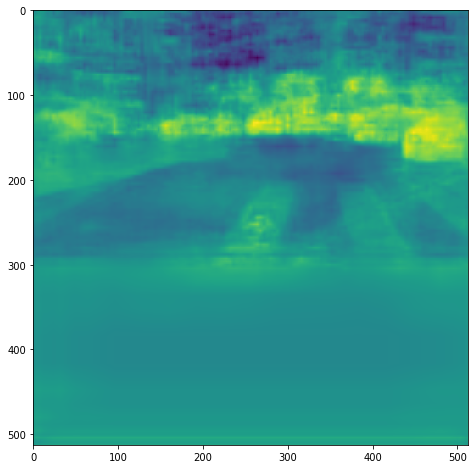

In [64]:
plt.figure(figsize = (12,8))
plt.imshow(out.detach().numpy()[2][13])

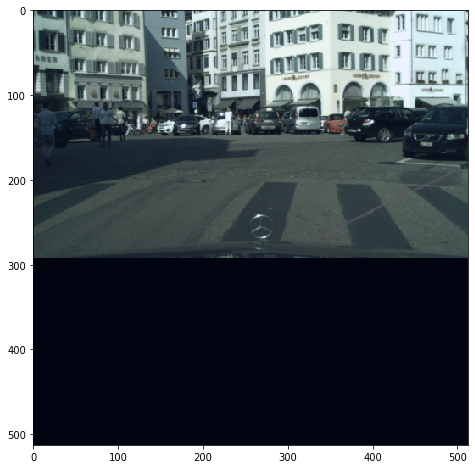

In [63]:
plt.figure(figsize = (12,8))
color_img = image[2].permute(1,2,0)
color_img = (color_img - color_img.min())/(color_img.max() - color_img.min())
plt.imshow(color_img)

# 看看last conv的参数

In [66]:
model.last_conv

Conv2d(160, 19, kernel_size=(1, 1), stride=(1, 1))

In [67]:
model.last_conv.__dict__.keys()

dict_keys(['_backend', '_parameters', '_buffers', '_backward_hooks', '_forward_hooks', '_forward_pre_hooks', '_state_dict_hooks', '_load_state_dict_pre_hooks', '_modules', 'training', 'in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'transposed', 'output_padding', 'groups', 'padding_mode'])

In [68]:
model.last_conv._parameters.keys()

odict_keys(['weight', 'bias'])

In [69]:
model.last_conv._parameters['weight'].shape

torch.Size([19, 160, 1, 1])

# 看看conv_1的参数

In [70]:
model.conv_1

Conv2d(32, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [71]:
model.conv_1._parameters['weight'].shape

torch.Size([64, 32, 7, 7])

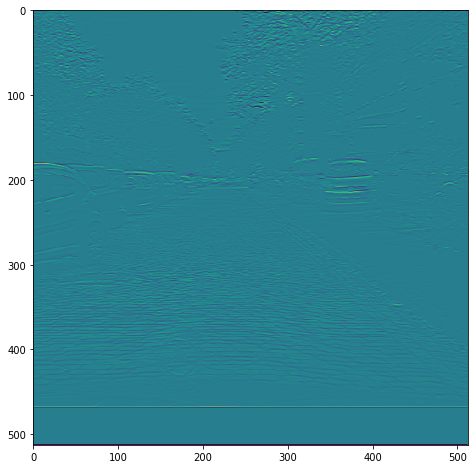

In [24]:
plt.figure(figsize = (12,8))
plt.imshow(sobel_x513[0][0])

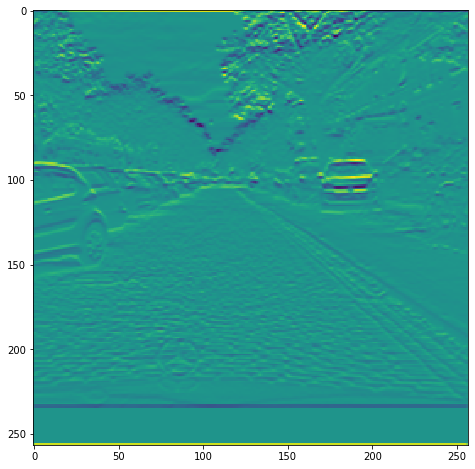

In [25]:
plt.figure(figsize = (12,8))
plt.imshow(sobel_x257[0][0])

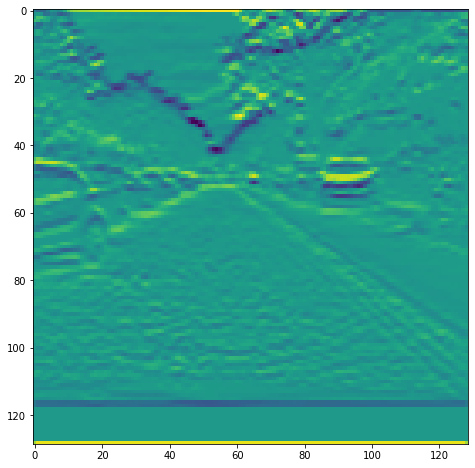

In [26]:
plt.figure(figsize = (12,8))
plt.imshow(sobel_x129[0][0])

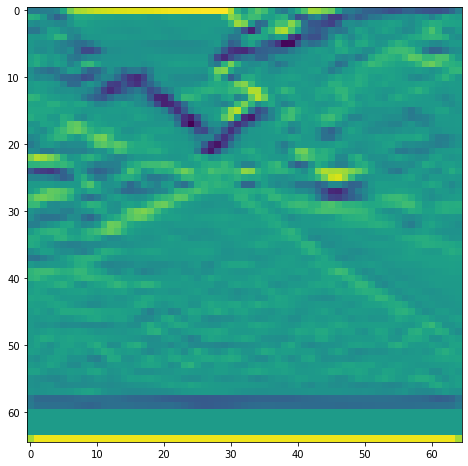

In [27]:
plt.figure(figsize = (12,8))
plt.imshow(sobel_x65[0][0])

In [ ]:
x513 = x513.view(bt_size, chn_size, x513.shape[2], x513.shape[3])
x257 = x257.view(bt_size, chn_size, x257.shape[2], x257.shape[3])
x129 = x129.view(bt_size, chn_size, x129.shape[2], x129.shape[3])
x65 = x65.view(bt_size, chn_size, x65.shape[2], x65.shape[3])

x513 = torch.cat((x513, line_x513, sobel_x513), 1)
x257 = torch.cat((x257, line_x257, sobel_x257), 1)
x129 = torch.cat((x129, line_x129, sobel_x129), 1)
x65 = torch.cat((x65, line_x65, sobel_x65), 1)

mix_x513 = model.conv513_mix(x513)
mix_x257 = model.conv257_mix(x257)
mix_x129 = model.conv513_mix(x129)
mix_x65 = model.conv65_mix(x65)

mix_x513 = model.bn_mix_513(mix_x513)
mix_x257 = model.bn_mix_257(mix_x257)
mix_x129 = model.bn_mix_129(mix_x129)
mix_x65 = model.bn_mix_65(mix_x65)
mix_x513 = F.relu(mix_x513)
mix_x257 = F.relu(mix_x257)
mix_x129 = F.relu(mix_x129)
mix_x65 = F.relu(mix_x65)

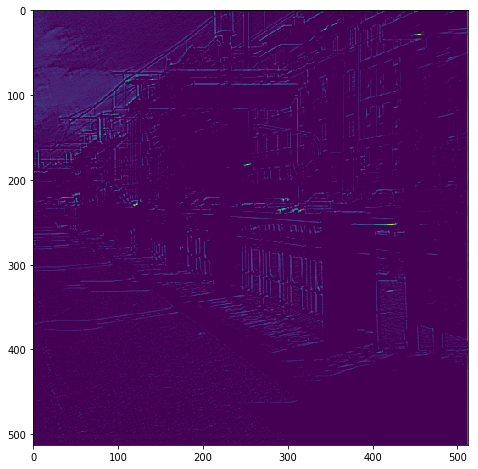

In [42]:
resize_513 = F.interpolate(mix_x513, size=(513,513), mode='bilinear', align_corners=True)
plt.figure(figsize = (12,8))
plt.imshow(resize_513[0][0].detach())

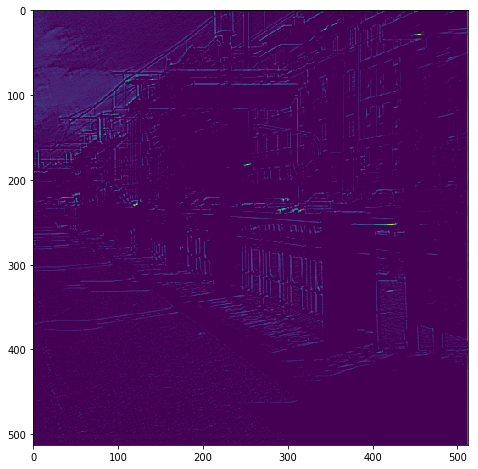

In [38]:
plt.figure(figsize = (12,8))
plt.imshow(mix_x513[0][0].detach())

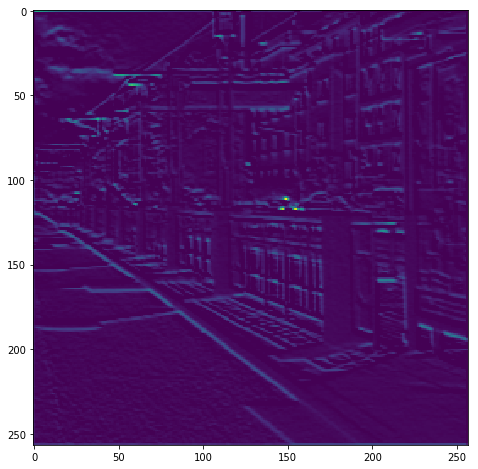

In [39]:
plt.figure(figsize = (12,8))
plt.imshow(mix_x257[0][0].detach())

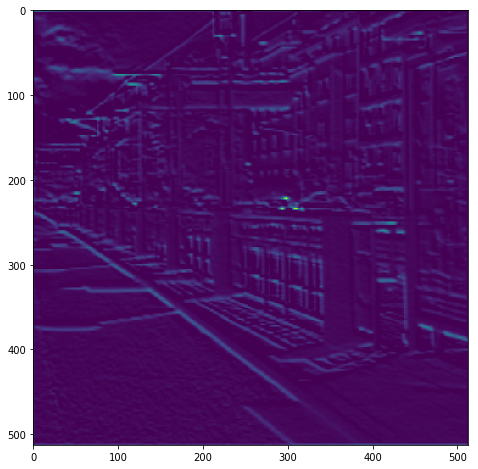

In [43]:
resize_513 = F.interpolate(mix_x257, size=(513,513), mode='bilinear', align_corners=True)
plt.figure(figsize = (12,8))
plt.imshow(resize_513[0][0].detach())

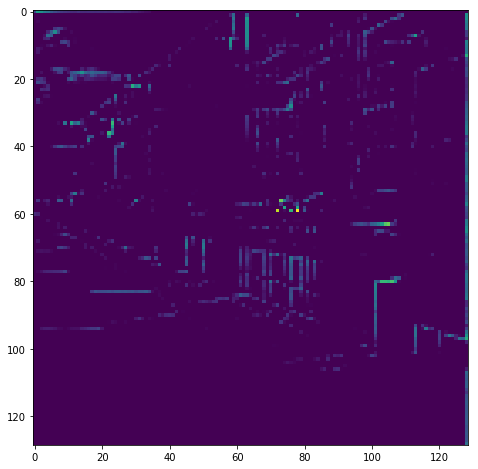

In [40]:
plt.figure(figsize = (12,8))
plt.imshow(mix_x129[0][0].detach())

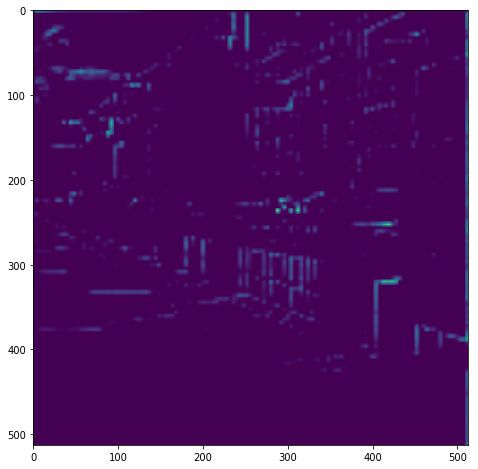

In [44]:
resize_513 = F.interpolate(mix_x129, size=(513,513), mode='bilinear', align_corners=True)
plt.figure(figsize = (12,8))
plt.imshow(resize_513[0][0].detach())

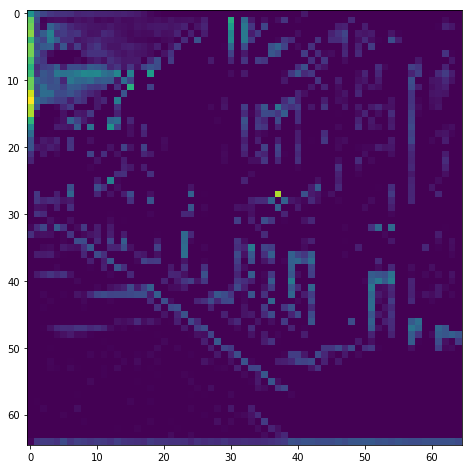

In [41]:
plt.figure(figsize = (12,8))
plt.imshow(mix_x65[0][0].detach())

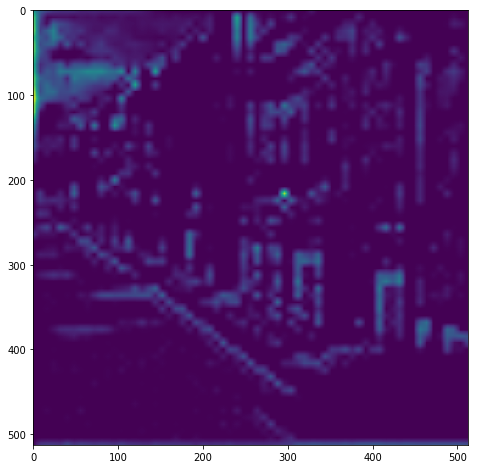

In [45]:
resize_513 = F.interpolate(mix_x65, size=(513,513), mode='bilinear', align_corners=True)
plt.figure(figsize = (12,8))
plt.imshow(resize_513[0][0].detach())

# 几次卷积的信息提取 利用7*7卷积总结信息

In [2]:
x513_257 = model.share_conv1(mix_x513)

NameError: name 'model' is not defined